<a href="https://colab.research.google.com/github/YMuskrat/Pneumonia-Detection-using-only-Transfer-Learning/blob/master/Medical%20Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#By Yassir Laaouach and Omar El Hassani El Idrissi
!pip install kaggle

In [ ]:
import glob, pylab, pandas as pd
import  numpy as np

In [ ]:
#Importing libraries
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
#Upload the dataset from Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yassirelaaouach","key":"19d2ff3235740e281787d251c5f0a805"}'}

In [ ]:
#Make a directory for the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Install Kaggle version
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Kaggle API 1.5.6


In [ ]:
#download the datasets
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle   competitions download -c rsna-pneumonia-detection-challenge

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
100% 3.66G/3.66G [00:46<00:00, 46.7MB/s]
100% 3.66G/3.66G [00:46<00:00, 84.9MB/s]


In [ ]:
#Unzip the files
!unzip -q "chest-xray-pneumonia.zip"
!unzip -q "/content/rsna-pneumonia-detection-challenge.zip"

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [ ]:
#you can see the patient Id with (x,y) representing the box where there is an abnormality
df = pd.read_csv('stage_2_train_labels.csv')
print(df.iloc[2])

patientId    00322d4d-1c29-4943-afc9-b6754be640eb
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 2, dtype: object


In [ ]:
#Let's the see the case where there is an abnormality (x,y) has values this time
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


In [ ]:
#install pydicom to read the images in the medical format
!pip install pydicom

     |████████████████████████████████| 35.3 MB 1.2 MB/s 


In [ ]:
# Let's see the metadata that we have here
import pydicom
patientId = df['patientId'][0]
dcmf = 'stage_2_train_images/%s.dcm' % patientId
dcm = pydicom.read_file(dcmf)

print(dcm)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

(-0.5, 1911.5, 1738.5, -0.5)

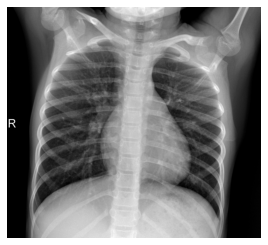

In [ ]:
#Sample of a picture
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')



In [ ]:
#Loading the training, validation and test set.
data = '/content/chest_xray/chest_xray/train'
data1='/content/chest_xray/chest_xray/val'
data2 = '/content/chest_xray/chest_xray/test'
train_imgs = os.listdir(data)
val_imgs= os.listdir(data1)
test_imgs= os.listdir(data2)
# see what is in the test, training and validation set
print(train_imgs)
print(val_imgs)
print(test_imgs)

['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


In [ ]:
#There is a hidden document here .DS_Store that is not visible so we need to take it off so we avoid any problems
!rm /content/chest_xray/chest_xray/val/.DS_Store

In [ ]:
#Same here
!rm /content/chest_xray/chest_xray/train/NORMAL/.DS_Store
!rm /content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store


In [ ]:
#Same here
!rm /content/chest_xray/chest_xray/val/NORMAL/.DS_Store
!rm /content/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store

In [ ]:
# we get the images along with their labels
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'PNEUMONIA':
            label = 1
        elif labels == 'NORMAL':
            label = 0
        
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            
            try:
              image = cv2.resize(image,(224,224))
            
              
            except cv2.error as e:
              
              print('invalid!')

               #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
            
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = { 1:'PNEUMONIA', 0:'NORMAL'}
    
    return labels[class_code]


In [ ]:
!ls chest_xray/chest_xray/test/

NORMAL	PNEUMONIA


In [ ]:
# We extract the images and their labels
from sklearn.utils import shuffle
TrainImage, TrainLabel = get_images('/content/chest_xray/chest_xray/train/') #Extract the training images from the folders.
valImage, valLabel = get_images('/content/chest_xray/chest_xray/val/') #Extract the training images from the folders.
 

TrainImages = np.array(TrainImage) #converting the list of images to numpy array.
TrainLabels = np.array(TrainLabel)
valImages = np.array(valImage) #converting the list of images to numpy array.
valLabels = np.array(valLabel)

In [ ]:
#Shape of the images and their labels
print("Shape of Images:",TrainImages.shape)
print("Shape of Labels:",TrainLabels.shape)
print("Shape of Images:",valImages.shape)
print("Shape of Labels:",valLabels.shape)

Shape of Images: (5216, 224, 224, 3)
Shape of Labels: (5216,)
Shape of Images: (16, 224, 224, 3)
Shape of Labels: (16,)


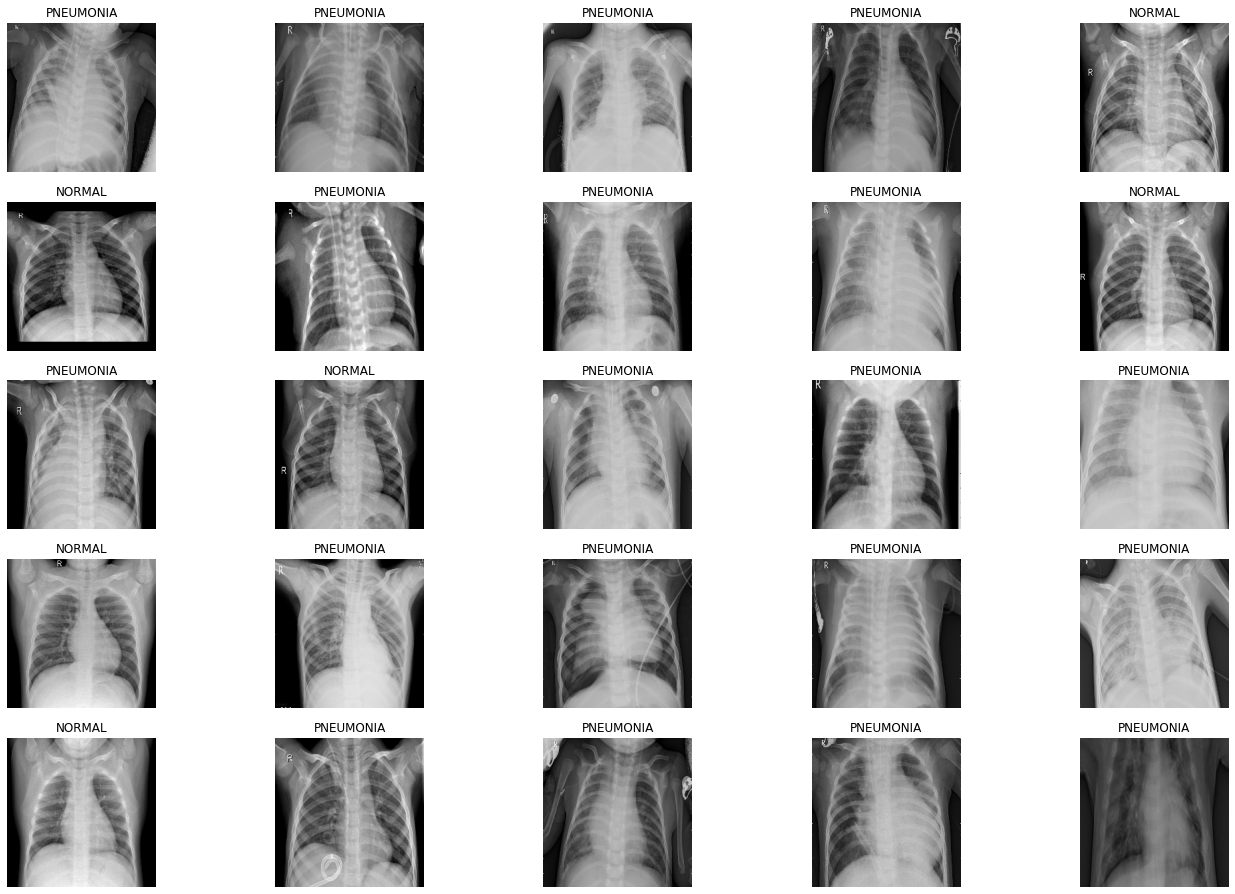

In [ ]:
#Print the pictures along with their Label
import matplotlib.pyplot as plot
from random import randint
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(TrainImages))
        ax[i,j].imshow(TrainImages[rnd_number])
        ax[i,j].set_title(get_classlabel(TrainLabels[rnd_number]))
        ax[i,j].axis('off')

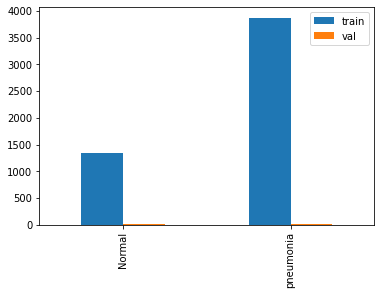

In [ ]:
##The portion of the images in the training set compared the validation set
import pandas as pd
La = ['Normal', 'pneumonia']
_, train_counts = np.unique(TrainLabels, return_counts=True)
_, val_counts = np.unique(valLabels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'val': test_counts}, 
             index=La
            ).plot.bar()
plt.show()

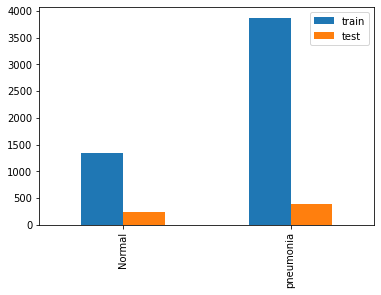

In [ ]:
#The portion of the images in the training set compared the test set
import pandas as pd
valImage, valLabel = get_images('/content/chest_xray/chest_xray/test/')
testImages = np.array(valImage) 
testLabels = np.array(valLabel)
La = ['Normal', 'pneumonia']
_, train_counts = np.unique(TrainLabels, return_counts=True)
_, test_counts = np.unique(testLabels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=La
            ).plot.bar()
plt.show()

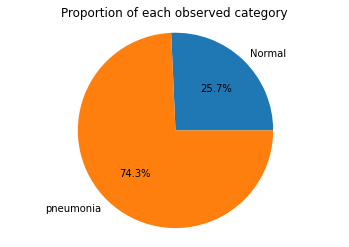

In [ ]:
# the porportion of the Normal and pneumonia cases in the validation set
import matplotlib.pyplot as plt
class_names = ['Normal', 'pneumonia']
plt.pie(train_counts,
        explode=(0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

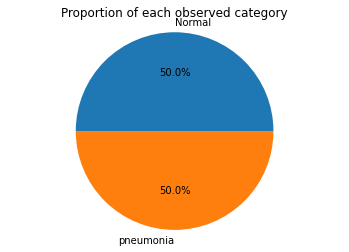

In [ ]:
# the porportion of the Normal and pneumonia cases in the validation set
import matplotlib.pyplot as plt
class_names = ['Normal', 'pneumonia']
plt.pie(val_counts,
        explode=(0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
# I have the weights on the google drive so we mount them from there
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip= True)
val_datagen=ImageDataGenerator(rescale=1./255)

training_set= train_datagen.flow_from_directory('/content/chest_xray/chest_xray/train', target_size=(224,224), batch_size=32, class_mode='categorical')
val_set= val_datagen.flow_from_directory('/content/chest_xray/chest_xray/val', target_size=(224,224), batch_size=32, class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# we use transfer learning here of densenet121 
IMG_SIZE=[224,224]

densenet=DenseNet121(input_shape= IMG_SIZE+[3], weights='imagenet', include_top=False)

for layer in densenet.layers:
  layer.trainable=False


In [ ]:
#intially we have densenet trained on imagenet, 
# we use that a base model and then we add logitic layer where we put the weights that are trained on chexnet
# we train the denselayer using the weight of chexnet( used in the paper by standford( detenction of pneumonia,2017))
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.utils import print_summary

chexnet_weights = '/content/gdrive/My Drive/best_weights.h5'
def get_chexnet_model():
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)
    
   

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )
   
    # load chexnet weights
    model.load_weights(chexnet_weights)

    # return model
    return base_model, model



base_model, model = get_chexnet_model()
    
print_summary(model)


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# we flattern the last layer anc change it to 2 outputs
x=Flatten()(densenet.output)
prediction=Dense(len(train_imgs), activation='softmax')(x)
dens=Model(inputs=densenet.input, outputs=prediction)
dens.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# We compile the model

dens.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# get the test set ready
test_set= val_datagen.flow_from_directory('/content/chest_xray/chest_xray/test', target_size=(224,224), batch_size=32, class_mode='categorical')


Found 624 images belonging to 2 classes.


In [ ]:
#Training the model over one epoch
k=dens.fit_generator(training_set, validation_data=test_set, epochs= 1, steps_per_epoch=len(training_set), validation_steps=len(val_set))

Epoch 1/1
163/163 [==============================] - 1191s 7s/step - loss: 0.3830 - accuracy: 0.9699 - val_loss: 1.8062 - val_accuracy: 0.8438


In [ ]:
#training the model over three epochs
final=dens.fit_generator(training_set, validation_data=test_set, epochs= 3, steps_per_epoch=len(training_set), validation_steps=len(val_set))

In [ ]:
dens.save_weights("/content/gdrive/My Drive/bestweights.h5")

In [ ]:
dens.save("/content/gdrive/My Drive/model.h5")

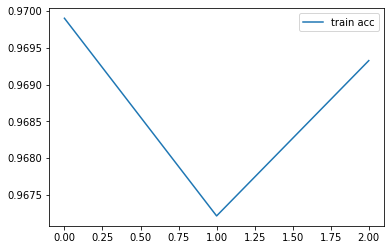

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot the trainin accuracy over time
plt.plot(final.history['accuracy'], label='train acc')

plt.legend()
plt.show()
plt.savefig('LossVal_loss')